In [1]:
!pip -q install numpy pandas scikit-learn matplotlib

In [4]:
import pandas as pd

print("\n[1] Loading UCI Dataset...")

# Load Letter Recognition dataset from UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data"
columns = ['letter', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 
           'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 
           'xegvy', 'y-ege', 'yegvx']

df = pd.read_csv(url, names=columns)
print(f"✓ Dataset loaded: {df.shape[0]} rows, {df.shape[1]-1} features")

# Set target column and csv path for compatibility with later cells
target_col = 'letter'
csv_path = 'letter_recognition.csv'
df.to_csv(csv_path, index=False)
df.head()



[1] Loading UCI Dataset...
✓ Dataset loaded: 20000 rows, 16 features
✓ Dataset loaded: 20000 rows, 16 features


,letter,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [5]:
import os, json, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

CSV = csv_path
TARGET = target_col    
OUT_DIR = "svm_results_fast"
N_SAMPLES = 10
ITERS = 100
KERNELS = ["linear", "rbf"]
PATIENCE = 12               # early stop if no improvement for 12 iters
CACHE_MB = 1024             # bigger kernel cache
NU_RANGE = (0.05, 0.95)
TOL_RANGE = (1e-5, 1e-3)    # acts as “epsilon” field in your table
SEEDS = [11,22,33,44,55,66,77,88,99,111]


os.makedirs(OUT_DIR, exist_ok=True)

# ---------- load ----------
data = pd.read_csv(CSV)
X_df = data.drop(columns=[TARGET])
y = data[TARGET]
tt = type_of_target(y)
if tt not in ("multiclass", "multiclass-indicator"):
    raise ValueError(f"Target must be multiclass; got {tt}")

if not (5000 <= len(data) <= 30000):
    print(f"Warning: dataset has {len(data)} rows (assignment asks 5k–30k). Proceeding anyway.")

def sample_params(rng):
    kernel = rng.choice(KERNELS)
    nu = float(rng.uniform(*NU_RANGE))
    tol = float(10 ** rng.uniform(math.log10(TOL_RANGE[0]), math.log10(TOL_RANGE[1])))
    params = {"kernel": kernel, "nu": nu, "tol": tol, "cache_size": CACHE_MB, "shrinking": True}
    if kernel in ("rbf", "sigmoid"):
        params["gamma"] = rng.choice(["scale","auto"])
    if kernel == "poly":
        params["degree"] = rng.integers(2,6)
        params["gamma"] = rng.choice(["scale","auto"])
        params["coef0"] = float(rng.uniform(0.0, 1.0))
    return params

summary_rows, all_curves = [], {}
start_all = time.time()

for i, seed in enumerate(SEEDS[:N_SAMPLES], start=1):
    S = f"S{i}"
    rng = np.random.default_rng(seed)

    # Split once per sample
    X_tr_df, X_te_df, y_tr, y_te = train_test_split(
        X_df, y, test_size=0.30, stratify=y, random_state=seed
    )

    # Scale ONCE per split (faster than fitting a Pipeline every loop)
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr_df).astype(np.float32)
    X_te = scaler.transform(X_te_df).astype(np.float32)

    best_acc = -1.0
    best_params = None
    curve = []
    no_improve = 0
    start_s = time.time()

    for it in range(1, ITERS+1):
        params = sample_params(rng)
        try:
            clf = NuSVC(**params)
            clf.fit(X_tr, y_tr)
            acc = accuracy_score(y_te, clf.predict(X_te))
        except Exception:
            acc = 0.0

        if acc > best_acc + 1e-6:
            best_acc = acc
            best_params = params
            no_improve = 0
        else:
            no_improve += 1

        curve.append(best_acc)

        # Early stopping
        if no_improve >= PATIENCE:
            # pad curve to keep length the same (optional)
            curve += [best_acc] * (ITERS - len(curve))
            break

    all_curves[S] = curve

    kernel = best_params["kernel"]
    nu = round(best_params["nu"], 4)
    epsilon = round(best_params["tol"], 6)

    summary_rows.append({
        "Sample #": S,
        "Best Accuracy": round(best_acc*100, 2),
        "Kernel": kernel,
        "Nu": nu,
        "Epsilon": epsilon,
        "Best SVM Parameters (JSON)": json.dumps(best_params, sort_keys=True)
    })

    dur = time.time() - start_s
    print(f"{S}: acc={best_acc:.4f} kernel={kernel} nu={nu} eps={epsilon} "
          f"(iters={len(curve)}/{ITERS}, {dur:.1f}s)")

summary = pd.DataFrame(summary_rows).sort_values("Sample #")
summary_path = os.path.join(OUT_DIR, "optimized_svm_summary.csv")
summary.to_csv(summary_path, index=False)
print(f"\nSaved table to: {summary_path}  | total time ≈ {time.time()-start_all:.1f}s")
summary


S1: acc=0.9642 kernel=rbf nu=0.0742 eps=0.000408 (iters=100/100, 1139.9s)
S2: acc=0.9013 kernel=rbf nu=0.2294 eps=1.5e-05 (iters=100/100, 251.1s)
S2: acc=0.9013 kernel=rbf nu=0.2294 eps=1.5e-05 (iters=100/100, 251.1s)
S3: acc=0.9600 kernel=rbf nu=0.0639 eps=0.000351 (iters=100/100, 360.5s)
S3: acc=0.9600 kernel=rbf nu=0.0639 eps=0.000351 (iters=100/100, 360.5s)
S4: acc=0.9563 kernel=rbf nu=0.0675 eps=0.000393 (iters=100/100, 276.0s)
S4: acc=0.9563 kernel=rbf nu=0.0675 eps=0.000393 (iters=100/100, 276.0s)
S5: acc=0.8598 kernel=rbf nu=0.3546 eps=0.00016 (iters=100/100, 360.6s)
S5: acc=0.8598 kernel=rbf nu=0.3546 eps=0.00016 (iters=100/100, 360.6s)
S6: acc=0.9213 kernel=rbf nu=0.1742 eps=0.000291 (iters=100/100, 545.4s)
S6: acc=0.9213 kernel=rbf nu=0.1742 eps=0.000291 (iters=100/100, 545.4s)
S7: acc=0.9630 kernel=rbf nu=0.0526 eps=8.4e-05 (iters=100/100, 823.9s)
S7: acc=0.9630 kernel=rbf nu=0.0526 eps=8.4e-05 (iters=100/100, 823.9s)
S8: acc=0.9312 kernel=rbf nu=0.1635 eps=9.7e-05 (iters=1

,Sample #,Best Accuracy,Kernel,Nu,Epsilon,Best SVM Parameters (JSON)
0,S1,96.42,rbf,0.0742,0.000408,"{""cache_size"": 1024, ""gamma"": ""auto"", ""kernel""..."
9,S10,90.88,rbf,0.2090,0.000017,"{""cache_size"": 1024, ""gamma"": ""auto"", ""kernel""..."
1,S2,90.13,rbf,0.2294,0.000015,"{""cache_size"": 1024, ""gamma"": ""scale"", ""kernel..."
2,S3,96.00,rbf,0.0639,0.000351,"{""cache_size"": 1024, ""gamma"": ""scale"", ""kernel..."
3,S4,95.63,rbf,0.0675,0.000393,"{""cache_size"": 1024, ""gamma"": ""auto"", ""kernel""..."
4,S5,85.98,rbf,0.3546,0.000160,"{""cache_size"": 1024, ""gamma"": ""scale"", ""kernel..."
5,S6,92.13,rbf,0.1742,0.000291,"{""cache_size"": 1024, ""gamma"": ""auto"", ""kernel""..."
6,S7,96.30,rbf,0.0526,0.000084,"{""cache_size"": 1024, ""gamma"": ""scale"", ""kernel..."
7,S8,93.12,rbf,0.1635,0.000097,"{""cache_size"": 1024, ""gamma"": ""scale"", ""kernel..."
8,S9,87.45,rbf,0.3285,0.000061,"{""cache_size"": 1024, ""gamma"": ""auto"", ""kernel""..."


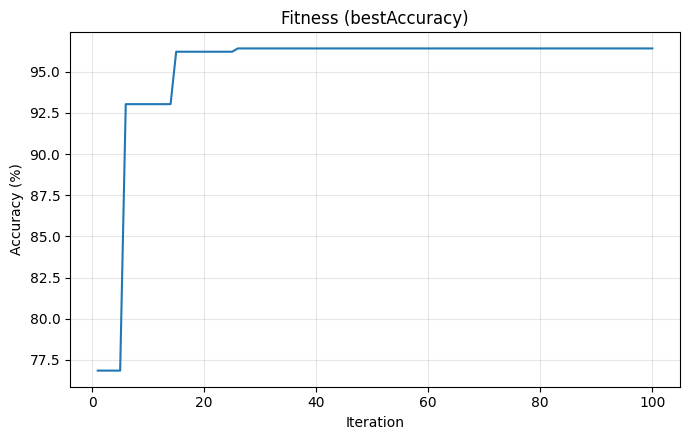

Saved convergence plot to: svm_results_fast\convergence_S1.png


In [7]:
best_idx = int(np.argmax(summary["Best Accuracy"].values))
best_sample = summary.iloc[best_idx]["Sample #"]
best_curve = all_curves[best_sample]

plt.figure(figsize=(7,4.5))
plt.plot(range(1, len(best_curve)+1), [v*100 for v in best_curve])
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.title("Fitness (bestAccuracy)")
plt.grid(True, alpha=0.3)
plot_path = os.path.join(OUT_DIR, f"convergence_{best_sample}.png")
plt.tight_layout()
plt.savefig(plot_path, dpi=150)
plt.show()

print(f"Saved convergence plot to: {plot_path}")
